# Code Credit
Modified from https://github.com/vntkumar8/musical-instrument-classification under Open Source license.

## Summary of changes
Increase classification ability by cleaning inputs of noise.

In [1]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np
from statistics import stdev
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import itertools

In [2]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
import tqdm

# Preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Noise reduce
import noisereduce as nr

# Creating features from audio files

In [5]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [6]:
file = open('../dataset/data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [14]:
Instruments = 'cel cla flu gac gel org pia sax tru vio voi'.split()
for i in Instruments:
    for filename in tqdm.tqdm(os.listdir(os.path.join('../dataset/IRMAS-TrainingData', f'{i}'))):
        songname = os.path.join('../dataset/IRMAS-TrainingData', i, filename)
        y, sr = librosa.load(songname, sr =44100)
        
        # Remove noise
        y = nr.reduce_noise(y=y, sr=sr)
        
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {i}'
        file = open('../dataset/data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

100%|██████████| 778/778 [03:53<00:00,  3.33it/s]


In [15]:
df = pd.read_csv('../dataset/data.csv')
df.head()

,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,008__[cel][nod][cla]0058__1.wav,0.005622,1273.967038,1974.181216,2121.477777,0.033642,-548.299316,189.765564,-21.121988,15.259335,...,-0.564254,1.159621,-0.287216,-1.051063,2.558362,7.008935,9.611934,6.723992,2.892501,cel
1,008__[cel][nod][cla]0058__2.wav,0.009950,1369.496771,1985.402338,2307.544605,0.035053,-492.253021,180.435959,-30.720634,16.488262,...,-3.774964,-4.976338,-5.985732,-12.421291,-7.708522,-5.190786,0.197547,10.872709,21.063335,cel
2,008__[cel][nod][cla]0058__3.wav,0.015884,1515.558971,2010.045759,2452.374103,0.041344,-445.286987,170.886612,-36.930515,13.339684,...,-1.129981,0.303812,2.144062,3.028069,4.692125,1.315577,-4.312213,-6.950765,-1.198687,cel
3,012__[cel][nod][cla]0043__1.wav,0.017558,1764.444040,2402.842740,3208.613545,0.042100,-370.563354,182.482651,-35.701279,31.877964,...,-3.459521,-4.016848,-2.542539,2.515918,3.337309,-1.405248,-2.197753,0.097689,-1.399735,cel
4,012__[cel][nod][cla]0043__2.wav,0.067676,10725.931851,6496.838211,18631.541649,0.467717,-92.736626,4.565805,3.992283,2.363016,...,-2.102218,-2.351212,-1.443668,-0.069437,0.735313,0.763398,0.884749,1.238959,0.887407,cel


In [16]:
df.shape
features = df[df.columns[2:26]]

# PCA Analysis

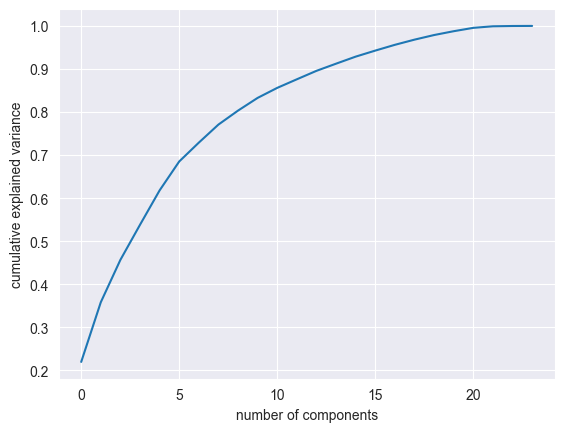

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
X = scale(features)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [18]:
# Dropping unneccesary columns
df = df.drop(['filename'],axis=1)

In [19]:
df1 = shuffle(df)

In [20]:
df1

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
8626,0.024198,3076.542455,1989.997820,4698.312130,0.122361,-475.451416,71.292343,17.021303,24.188211,7.201975,...,-5.350131,-2.507950,-0.208557,0.578532,1.396992,5.236618,3.536870,1.414671,-1.642788,gac
5516,0.127656,1410.252168,2362.181824,2784.600665,0.020523,-252.560974,169.912979,-18.384808,32.018127,17.226864,...,6.781163,0.405570,3.007869,5.307395,-4.655406,2.179958,5.655919,2.426144,-5.679547,vio
9028,0.031301,3785.659517,2712.532694,6464.201066,0.135393,-357.516296,55.421791,-58.464046,36.769123,-5.043067,...,4.764721,1.721685,-6.241275,-1.334218,-2.655183,0.106153,2.146872,0.116365,-8.883797,gel
8130,0.019984,2305.829037,2538.329343,4586.073427,0.051215,-435.148499,128.597397,8.681708,27.056753,7.888887,...,-0.371636,1.005497,0.318959,0.028223,-7.429859,-5.181813,-4.554732,0.494720,-2.573977,gac
7313,0.009618,1404.988202,1585.580377,2589.887299,0.044573,-571.481567,110.968208,6.205712,14.794125,10.945524,...,-2.994416,-3.977622,-2.649948,-3.242526,-5.155359,-5.564484,-4.069054,-0.882358,-4.034484,cla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13332,0.033655,3272.865930,3294.376461,6609.030564,0.088356,-318.671844,111.594116,-33.313213,47.613297,-16.664497,...,8.797430,0.430612,3.257554,3.285075,2.859953,-3.508206,-8.018579,-3.411285,-7.540751,voi
12993,0.035546,3787.576683,2127.532672,5236.725348,0.142838,-494.936951,99.344582,5.256700,35.248844,3.502169,...,-8.771290,-11.064209,-7.197446,-10.351682,-7.038359,-10.182324,-5.724533,-5.800463,-15.707106,voi
483,0.040656,1088.461144,1559.977193,1784.345967,0.031331,-407.826721,202.798828,-9.290714,13.320162,25.935856,...,14.959416,14.622413,4.546632,-2.537428,-18.728054,-26.514580,-13.850488,0.375268,2.523829,cla
7311,0.008675,4502.079202,3306.063469,7915.239654,0.165233,-588.129211,38.861980,-28.473320,3.078369,-25.552214,...,1.869619,-24.607313,-28.349302,-9.868462,5.421482,14.425664,8.371114,1.877018,0.948045,cla


In [21]:
instru_list = df1.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(instru_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

from joblib import dump
dump(scaler, 'std_scaler_denoise.bin', compress=True)

['std_scaler_denoise.bin']

In [22]:
y

array([3, 9, 4, ..., 1, 1, 3])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Supervised Algorithms

### SVM

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions
param_dist = {'C': uniform(0.1, 20),          # Uniform distribution between 0.1 and 20
              'kernel': ['rbf'],
              'degree': randint(2, 5),          # Discrete uniform distribution between 2 and 4
              'gamma': [0.1, 1, 10, 100]}

# Create the SVC model
svc = SVC()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)

Best Parameters:  {'C': 14.364895744459899, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


In [24]:
svc = SVC(kernel='rbf', C = 10.78, degree=3, gamma=0.1, probability=True)

In [25]:
print(X_train[0], y_train[0])

[ 0.84665222 -0.4951911   0.01582919 -0.24914336 -0.72635172  0.64795566
  0.49500898  0.40404007  2.18705037 -1.46233165  1.69160819 -0.34245217
  1.1872013   1.41669386 -0.06750063  1.22298487 -0.1921469   0.82862558
 -0.47837188 -0.54131256 -0.85383997 -0.08175389 -0.86168322 -0.1551388
  0.05752114] 6


In [26]:
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.6112560566530004

# Save the model

In [27]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "their_tuned_model_denoise.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
#Ypredict = pickle_model.predict(Xtest)

Test score: 61.13 %


In [28]:
predicted_labels = svc.predict(X_test)

In [29]:
print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
print(confusion_matrix(y_test, predicted_labels))

Recall:  [0.65753425 0.62200957 0.52380952 0.68582375 0.63265306 0.65625
 0.63414634 0.51464435 0.61637931 0.52173913 0.62662338]
Precision:  [0.57142857 0.58295964 0.48058252 0.57928803 0.64808362 0.68231047
 0.62758621 0.58293839 0.67772512 0.58536585 0.65202703]
F1-Score:  [0.61146497 0.60185185 0.50126582 0.62807018 0.64027539 0.66902655
 0.63084922 0.54666667 0.64559819 0.55172414 0.63907285]
Accuracy: 0.61  , 1640
Number of samples: 2683
[[ 96   3   8  10   2   5   4   2   4  10   2]
 [  8 130  10   7   4   4  11   8  12   7   8]
 [  8  17  99   6   7   8  17   9   3   8   7]
 [ 12   9   5 179   8   6  10   6   3   9  14]
 [  5   9   6  11 186  14  16  15   6   7  19]
 [  3   1  21  11  16 189  12   4   6   6  19]
 [  5  17  13  19  11  11 182   8   8   9   4]
 [  7  12   8  13   9   8  19 123  13  11  16]
 [  7   8  13   8   7   8   7  16 143  11   4]
 [ 14  12  12  20  13   5   6  11   7 120  10]
 [  3   5  11  25  24  19   6   9   6   7 193]]


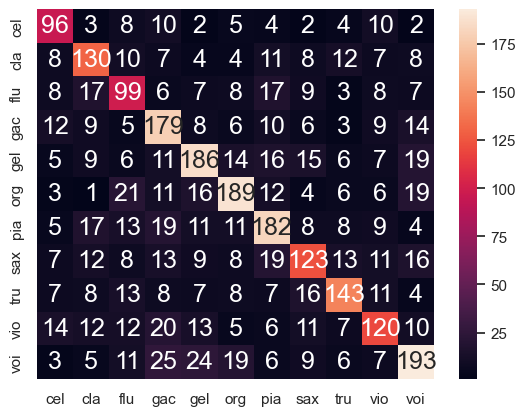

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt  
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted_labels),index=Instruments, columns=Instruments)
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 18},fmt='g')# font size

plt.show()